# Training a DeepSpeech LSTM Model using the LibriSpeech Data 
At the end of Chapter 16 and into Chapter 17 in the book it is suggested try and build an automatic speech recognition system using the LibriVox corpus and long short term memory (LSTM) models just learned in the Recurrent Neural Network (RNN) chapter. This particular excercise turned out to be quite difficult mostly from the perspective again of simply gathering and formatting the data, combined with the work to understand the LSTM was doing. As it turns out, in doing this assignment I taught myself about MFCCs (mel frequency cepstral coefficient) which are simply what is going on in the  Bregman Toolkit example earlier in the book. It's a process to convert audio into *num_cepstrals* coefficients using an FFT, and to use those coeffiicents as amplitudes and convert from the frequency into the time domain. LSTMs need time series data and a number of audio files converted using MFCCs into frequency amplitudes corresponding to utterances that you have transcript data for and you are in business!

The other major lesson was finding [RNN-Tutorial](https://github.com/mrubash1/RNN-Tutoria) an existing GitHub repository that implements a simplified version of the [deepspeech model](https://github.com/mozilla/DeepSpeech) from Mozilla which is a TensorFlow implementation of the Baidu model from the [seminal paper](https://arxiv.org/abs/1412.5567) in 2014.

I had to figure out along the way how to tweak hyperparameters including epochs, batch size, and training data. But overall this is a great architecture and example of how to use validation/dev sets during training for looking at validation loss compared to train loss and then overall to measure test accuracy.

### Data Preprocessing Steps:
   1. Grab all text files which start out as the full speech from all subsequent \*.flac files
   2. Each line in the text file contains:
       ```
       filename(without .txt at end) the speech present in the file, e.g., words separated by spaces
       filename N ... words ....
       ```
   3. Then convert all \*.flac files to \*.wav files, using `flac2wav`
   4. Remove all the flac files and remove the \*.trans.txt files
   5. Run this code in the notebook below to generate the associated \*.txt file to go along with each \*.wav file.
   6. Move all the \*.wav and \*.txt files into a single folder, e.g., `LibriSpeech/train-clean-all` 
   7. Repeat for test and dev
   
Once complete, you have a dataset to run through [RNN-Tutorial](https://github.com/mrubash1/RNN-Tutorial.git)

### References
   1. [PyDub](https://github.com/jiaaro/pydub) - PyDub library
   2. [A short reminder of how CTC works](https://towardsdatascience.com/beam-search-decoding-in-ctc-trained-neural-networks-5a889a3d85a7)
   3. [OpenSLR - LibriSpeech corpus](http://www.openslr.org/12)
   4. [Hamsa's Deep Speech notebook](https://github.com/cosmoshsv/Deep-Speech/blob/master/DeepSpeech_RNN_Training.ipynb)
   5. [LSTM's by example using TensorFlow](https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537) 
   6. [How to read an audio file using TensorFlow APIs](https://github.com/tensorflow/tensorflow/issues/28237)
   7. [Audio spectrograms in TensorFlow](https://mauri870.github.io/blog/posts/audio-spectrograms-in-tensorflow/)
   8. [Reading audio files using TensorFlow](https://github.com/tensorflow/tensorflow/issues/32382)
   9. [TensorFlow's decode_wav API](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav)
   10. [Speech Recognition](https://towardsdatascience.com/speech-recognition-analysis-f03ff9ce78e9)
   11. [Using TensorFlow's audio ops](https://stackoverflow.com/questions/48660391/using-tensorflow-contrib-framework-python-ops-audio-ops-audio-spectrogram-to-gen)
   12. [LSTM by Example - Towards Data Science](https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537)
   13. [Training your Own Model -  DeepSpeech](https://deepspeech.readthedocs.io/en/v0.7.3/TRAINING.html)
   14. [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
   15. [Implementing  LSTMs](https://apaszke.github.io/lstm-explained.html)
   16. [Mel Frequency Cepstral Coefficient](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
   17. [TensorFlow - Extract Every Other Element](https://stackoverflow.com/questions/46721407/tensorflow-extract-every-other-element)
   18. [Plotting MFCCs in TensorFlow](https://stackoverflow.com/questions/47056432/is-it-possible-to-get-exactly-the-same-results-from-tensorflow-mfcc-and-librosa)
   19. [MFCCs in TensorFlow](https://kite.com/python/docs/tensorflow.contrib.slim.rev_block_lib.contrib_framework_ops.audio_ops.mfcc)
   20. [How to train Baidu's Deep Speech Model with Kur](https://blog.deepgram.com/how-to-train-baidus-deepspeech-model-with-kur/)
   21. [Silicon Valley Data Science SVDS - RNN Tutorial](https://www.svds.com/tensorflow-rnn-tutorial/)
   22. [Streaming RNNs with TensorFlow](https://hacks.mozilla.org/2018/09/speech-recognition-deepspeech/)
   

In [1]:
import sys

In [2]:
sys.path.append("../../libs/basic_units/")

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.audio import decode_wav
from tensorflow.raw_ops import Mfcc, AudioSpectrogram
from tqdm.notebook import tqdm
from basic_units import cm, inch
import glob
from scipy import signal
import soundfile as sf
import os
import time
import csv

In [4]:
speech_data_path = "../../data/LibriSpeech"
train_path = speech_data_path + "/train-clean-100"
dev_path = speech_data_path + "/dev-clean"
test_path = speech_data_path + "/test-clean"

In [5]:
train_transcripts = [file for file in glob.glob(train_path + "/*/*/*.txt")]
dev_transcripts = [file for file in glob.glob(dev_path + "/*/*/*.txt")]
test_transcripts = [file for file in glob.glob(test_path + "/*/*/*.txt")]

In [6]:
train_audio_wav = [file for file in glob.glob(train_path + "/*/*/*.wav")]
dev_audio_wav = [file for file in glob.glob(dev_path + "/*/*/*.wav")]
test_audio_wav = [file for file in glob.glob(test_path + "/*/*/*.wav")]

In [7]:
sys.path.append("../../libs/RNN-Tutorial/src") 

In [8]:
numcep=26
numcontext=9

(163840, 1)
16000
[[[-1.2924805e+00 -1.6727712e+00  2.6565906e-01 ... -4.9464533e-01
   -8.0459461e-02 -2.4568604e-01]
  [-1.3827541e+00 -1.6454916e+00  2.7615392e-01 ... -4.9200761e-01
   -8.6767256e-02 -2.2917633e-01]
  [-1.5100304e+00 -1.5856098e+00  3.4048718e-01 ... -4.5024821e-01
   -7.9039715e-02 -1.7609477e-01]
  ...
  [-3.8997927e+00 -9.6423161e-01 -5.6239200e-01 ... -2.0234044e-01
   -1.3896421e-01  4.8706021e-02]
  [-3.8434243e+00 -9.2779779e-01 -5.9620500e-01 ... -1.0271078e-01
   -9.9897847e-02  1.9752394e-02]
  [-3.8488970e+00 -9.0062475e-01 -6.3511568e-01 ...  2.8306339e-03
   -5.6673948e-02 -5.8116550e-03]]]
(1, 2545, 26)


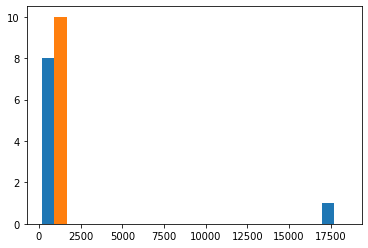

In [9]:
filename =  '../../data/LibriSpeech/train-clean-100/3486/166424/3486-166424-0004.wav'
raw_audio = tf.io.read_file(filename)
audio, fs = decode_wav(raw_audio)
print(np.shape(audio.numpy()))
print(fs.numpy())

# Get mfcc coefficients
spectrogram = AudioSpectrogram(
        input=audio, window_size=1024,stride=64)
orig_inputs = Mfcc(spectrogram=spectrogram, sample_rate=fs, dct_coefficient_count=numcep)

audio_mfcc = orig_inputs.numpy()
print(audio_mfcc)
print(np.shape(audio_mfcc))
hist_audio = np.histogram(audio_mfcc, bins=range(9 + 1))
plt.hist(hist_audio)
plt.show()

[ 0.15  1.15  2.15  3.15  4.15  5.15  6.15  7.15  8.15  9.15 10.15 11.15
 12.15 13.15 14.15 15.15 16.15 17.15 18.15 19.15 20.15 21.15 22.15 23.15
 24.15 25.15]


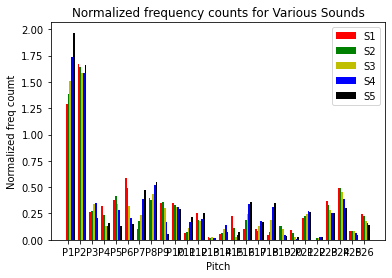

In [10]:
labels=[]
for i in np.arange(26):
    labels.append("P"+str(i+1))
    
fig, ax = plt.subplots()
ind = np.arange(len(labels))
width = 0.15
colors = ['r', 'g', 'y', 'b', 'black']
plots = []

for i in range(0, 5):
    Xs = np.asarray(np.abs(audio_mfcc[0][i])).reshape(-1)
    p = ax.bar(ind + i*width, Xs, width, color=colors[i])
    plots.append(p[0])

xticks = ind + width / (audio_mfcc.shape[0])
print(xticks)
ax.legend(tuple(plots), ('S1', 'S2', 'S3', 'S4', 'S5'))
ax.yaxis.set_units(inch)
ax.autoscale_view()
ax.set_xticks(xticks)
ax.set_xticklabels(labels)

ax.set_ylabel('Normalized freq coumt')
ax.set_xlabel('Pitch')
ax.set_title('Normalized frequency counts for Various Sounds')
plt.show()

In [11]:
filename =  '../../data/LibriSpeech/train-clean-100/3486/166424/3486-166424-0004.wav'
raw_audio = tf.io.read_file(filename)
audio, fs = decode_wav(raw_audio)

wsize = 16384 #1024
stride = 448 #64


# Get mfcc coefficients
spectrogram = AudioSpectrogram(
        input=audio, window_size=wsize,stride=stride)
numcep=26
numcontext=9
orig_inputs = Mfcc(spectrogram=spectrogram, sample_rate=fs, dct_coefficient_count=numcep) 
orig_inputs = orig_inputs[:,::2]

audio_mfcc = orig_inputs.numpy()
print(audio_mfcc)
print(np.shape(audio_mfcc))

train_inputs = np.array([], np.float32)
train_inputs.resize((audio_mfcc.shape[1], numcep + 2 * numcep * numcontext))

# Prepare pre-fix post fix context
empty_mfcc = np.array([])
empty_mfcc.resize((numcep))
empty_mfcc = tf.convert_to_tensor(empty_mfcc, dtype=tf.float32)
empty_mfcc_ev = empty_mfcc.numpy()

# Prepare train_inputs with past and future contexts
# This code always takes 9 time steps previous and 9 time steps in the future along with the current time step
time_slices = range(train_inputs.shape[0])
context_past_min = time_slices[0] + numcontext #starting min point for past content, has to be at least 9 ts
context_future_max = time_slices[-1] - numcontext  #ending point  max for future content, size time slices - 9ts

for time_slice in tqdm(time_slices):
    #print('time slice %d ' % (time_slice))
    # Reminder: array[start:stop:step]
    # slices from indice |start| up to |stop| (not included), every |step|

    # Add empty context data of the correct size to the start and end
    # of the MFCC feature matrix

    # Pick up to numcontext time slices in the past, and complete with empty
    # mfcc features
    need_empty_past = max(0, (context_past_min - time_slice))
    empty_source_past = np.asarray([empty_mfcc_ev for empty_slots in range(need_empty_past)])
    data_source_past = orig_inputs[0][max(0, time_slice - numcontext):time_slice]
    assert(len(empty_source_past) + data_source_past.numpy().shape[0] == numcontext)

    # Pick up to numcontext time slices in the future, and complete with empty
    # mfcc features
    need_empty_future = max(0, (time_slice - context_future_max))
    empty_source_future = np.asarray([empty_mfcc_ev for empty_slots in range(need_empty_future)])
    data_source_future = orig_inputs[0][time_slice + 1:time_slice + numcontext + 1]
    assert(len(empty_source_future) + data_source_future.numpy().shape[0] == numcontext)

    # pad if needed for the past or future, or else simply take past and future
    if need_empty_past:
        past = tf.concat([tf.cast(empty_source_past, tf.float32), tf.cast(data_source_past, tf.float32)], 0)
    else:
        past = data_source_past

    if need_empty_future:
        future = tf.concat([tf.cast(data_source_future, tf.float32), tf.cast(empty_source_future, tf.float32)], 0)
    else:
        future = data_source_future


    past = tf.reshape(past, [numcontext*numcep])
    now = orig_inputs[0][time_slice]
    future  = tf.reshape(future, [numcontext*numcep])

    train_inputs[time_slice] = np.concatenate((past.numpy(), now.numpy(), future.numpy()))
    assert(train_inputs[time_slice].shape[0] == numcep + 2*numcep*numcontext)

train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)
print('Train inputs shape %s ' % str(np.shape(train_inputs)))
print('Train inputs '+str(train_inputs))


[[[ 4.30906334e+01 -2.03534174e+00  2.13124916e-01 ... -1.80211738e-01
   -1.85429707e-01 -2.71477193e-01]
  [ 4.31706581e+01 -2.00894237e+00  1.24617569e-01 ... -1.76925331e-01
   -1.90575659e-01 -2.57524341e-01]
  [ 4.31397552e+01 -1.99346173e+00  2.48030107e-02 ... -1.74366608e-01
   -2.01282144e-01 -2.28919283e-01]
  ...
  [ 3.75711555e+01  1.11948147e-01 -1.20602953e+00 ... -1.09063618e-01
   -1.47348404e-01 -4.01394591e-02]
  [ 3.72089195e+01  1.13353238e-01 -1.15313697e+00 ... -1.19969286e-01
   -1.65252820e-01 -3.10349297e-02]
  [ 3.66761971e+01  7.20925033e-02 -1.06190836e+00 ... -1.32965922e-01
   -1.79992720e-01 -2.88166851e-02]]]
(1, 165, 26)



Train inputs shape (165, 494) 
Train inputs [[-0.1549316  -0.1549316  -0.1549316  ... -0.16783054 -0.17190124
  -0.15780927]
 [-0.1549316  -0.1549316  -0.1549316  ... -0.16929814 -0.1677892
  -0.16038078]
 [-0.1549316  -0.1549316  -0.1549316  ... -0.17141952 -0.16438814
  -0.16207673]
 ...
 [ 4.868814   -0.3211337  -0.11208492 ... -0.1549316  -0.1549316
  -0.1549316 ]
 [ 4.8369946  -0.31495303 -0.11409124 ... -0.1549316  -0.1549316
  -0.1549316 ]
 [ 4.819872   -0.30001065 -0.13118725 ... -0.1549316  -0.1549316
  -0.1549316 ]]


In [12]:
preprocessing = {
    'data_dir': train_path,
    'cache_dir' : '../../data/cache/LibriSpeech',
    'window_size': 20,
    'step_size': 10
}

model = {
    'verbose': 1,
    'conv_channels': [100],
    'conv_filters': [5],
    'conv_strides': [2],
    'rnn_units': [64],
    'bidirectional_rnn': True,
    'future_context': 2,
    'use_bn': True,
    'learning_rate': 0.001

}

training = {
    'tensorboard': False,
    'log_dir': './logs',
    'batch_size': 5,
    'epochs': 5,
    'validation_size': 0.2,
    'max_train' : 100
}

In [13]:
if not os.path.exists(preprocessing['cache_dir']):
    os.makedirs(preprocessing['cache_dir'])

In [14]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=20)

In [15]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [16]:
def ctc(y_true, y_pred):
    return y_pred

In [17]:
class SpeechModel(object):

    def __init__(self, hparams):

        input_data = tf.keras.layers.Input(name='inputs', shape=[hparams['max_input_length'], 161])
        x = input_data

        if hparams['use_bn']:
            x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.ZeroPadding1D(padding=(0, hparams['max_input_length']))(x)
        for i in range(len(hparams['conv_channels'])):
            x = tf.keras.layers.Conv1D(hparams['conv_channels'][i], hparams['conv_filters'][i],
                                       strides=hparams['conv_strides'][i], activation='relu', padding='same')(x)

        if hparams['use_bn']:
            x = tf.keras.layers.BatchNormalization()(x)

        for h_units in hparams['rnn_units']:
            if hparams['bidirectional_rnn']:
                h_units = int(h_units / 2)
            gru = tf.keras.layers.GRU(h_units, activation='relu', return_sequences=True)
            if hparams['bidirectional_rnn']:
                gru = tf.keras.layers.Bidirectional(gru, merge_mode='sum')
            x = gru(x)

        if hparams['use_bn']:
            x = tf.keras.layers.BatchNormalization()(x)

        if hparams['future_context'] > 0:
            if hparams['future_context'] > 1:
                x = tf.keras.layers.ZeroPadding1D(padding=(0, hparams['future_context'] - 1))(x)
            x = tf.keras.layers.Conv1D(100, hparams['future_context'], activation='relu')(x)

        y_pred = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hparams['vocab_size'] + 1,
                                                                       activation='sigmoid'))(x)

        labels = tf.keras.layers.Input(name='labels', shape=[None], dtype='int32')
        input_length = tf.keras.layers.Input(name='input_lengths', shape=[1], dtype='int32')
        label_length = tf.keras.layers.Input(name='label_lengths', shape=[1], dtype='int32')

        loss_out = tf.keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred,
                                                                                           labels,
                                                                                           input_length,
                                                                                           label_length])

        self.model = tf.keras.Model(inputs=[input_data, labels, input_length, label_length], outputs=[loss_out])

        if hparams['verbose']:
            print(self.model.summary())

        optimizer = tf.keras.optimizers.Adam(lr=hparams['learning_rate'], beta_1=0.9, beta_2=0.999,
                                             epsilon=1e-8, clipnorm=5)

        self.model.compile(optimizer=optimizer, loss=ctc)

    def train_generator(self, generator, train_params):
        callbacks = []

        if train_params['tensorboard']:
            callbacks.append(tf.keras.callbacks.TensorBoard(train_params['log_dir'], write_images=True))

        self.model.fit(generator, epochs=train_params['epochs'],
                                 steps_per_epoch=train_params['steps_per_epoch'],
                                 callbacks=callbacks)

In [18]:
def create_character_mapping():
    character_map = {' ': 0}

    for i in range(97, 123):
        character_map[chr(i)] = len(character_map)

    return character_map

In [19]:
def get_data_details(filename):
    result = {
        'max_input_length': 0,
        'max_label_length': 0,
        'num_samples': 0
    }

    # Get max lengths
    with open(filename, 'r') as metadata:
        metadata_reader = csv.DictReader(metadata, fieldnames=['filename', 'spec_length', 'labels_length', 'labels'])
        next(metadata_reader)
        for row in metadata_reader:
            if int(row['spec_length']) > result['max_input_length']:
                result['max_input_length'] = int(row['spec_length'])
            if int(row['labels_length']) > result['max_label_length']:
                result['max_label_length'] = int(row['labels_length'])
            result['num_samples'] += 1

    return result

In [20]:
def create_data_generator(directory, max_input_length, max_label_length, batch_size=64, num_epochs=5):
    x, y, input_lengths, label_lengths = [], [], [], []
    epochs = 0
    
    while epochs < num_epochs:
        with open(os.path.join(directory, 'LibriSpeech-metadata.csv'), 'r') as metadata:
            metadata_reader = csv.DictReader(metadata, fieldnames=['filename', 'spec_length', 'labels_length', 'labels'])
            next(metadata_reader)
            for row in metadata_reader:
                audio = np.load(os.path.join(directory, row['filename'] + '.npy'))
                x.append(audio)
                y.append([int(i) for i in row['labels'].split(' ')])
                input_lengths.append(row['spec_length'])
                label_lengths.append(row['labels_length'])
                if len(x) == batch_size:
                    yield {
                        'inputs': tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_input_length, padding='post'),
                        'labels': tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=max_label_length, padding='post'),
                        'input_lengths': np.asarray(input_lengths, dtype=np.int32),
                        'label_lengths': np.asarray(label_lengths, dtype=np.int32)
                    }, {
                        'ctc': np.zeros([batch_size])
                    }
                    x, y, input_lengths, label_lengths = [], [], [], []
        epochs = epochs + 1
                

In [21]:
def log_linear_specgram(audio, sample_rate, window_size=20,
                        step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    _, _, spec = signal.spectrogram(audio, fs=sample_rate,
                                    window='hann', nperseg=nperseg, noverlap=noverlap,
                                    detrend=False)

    return np.log(spec.T.astype(np.float32) + eps)


def preprocess_librispeech(directory):
    print("Pre-processing LibriSpeech corpus")

    start_time = time.time()
    character_mapping = create_character_mapping()

    if not os.path.exists(preprocessing['data_dir']):
        os.makedirs(preprocessing['data_dir'])

    dir_walk = list(os.walk(directory))
    num_hours = 0
    num_train = 0

    with open(os.path.join(preprocessing['cache_dir'] + '/LibriSpeech-metadata.csv'), 'w', newline='') as metadata:
        metadata_writer = csv.DictWriter(metadata, fieldnames=['filename', 'spec_length', 'labels_length', 'labels'])
        metadata_writer.writeheader()
        for root, dirs, files in tqdm(dir_walk):
            for file in files:
                if file[-4:] == '.txt' and num_train < training['max_train']:
                    filename = os.path.join(root, file)
                    with open(filename, 'r') as f:
                        txt = f.read().split(' ')
                        
                        filename_base_no_path = os.path.splitext(file)[0]
                        filename_base = os.path.splitext(filename)[0]
                        filename_wav = filename_base + '.wav'
                        audio, sr = sf.read(filename_wav)
                        num_hours += (len(audio) / sr) / 3600
                        spec = log_linear_specgram(audio, sr, window_size=preprocessing['window_size'],
                                                   step_size=preprocessing['step_size'])
                        np.save(os.path.join(preprocessing['cache_dir'], filename_base_no_path) + '.npy', spec)
                        ids = [character_mapping[c] for c in ' '.join(txt).lower()
                               if c in character_mapping]
                        metadata_writer.writerow({
                            'filename': filename_base_no_path,
                            'spec_length': spec.shape[0],
                            'labels_length': len(ids),
                            'labels': ' '.join([str(i) for i in ids])
                        })
                            
                        if num_train + 1 <= training['max_train']:
                            num_train = num_train + 1
                            
            
            if num_train >= training['max_train']:
                print('Processed {} files: max train {} reached...'.format(num_train, training['max_train']))
                break

    print("Done!")
    print("Hours pre-processed: " + str(num_hours))
    print("Time: " + str(time.time() - start_time))

In [22]:
preprocess_librispeech(preprocessing['data_dir'])

Pre-processing LibriSpeech corpus


Processed 100 files: max train 100 reached...

Done!
Hours pre-processed: 0.388797204861111
Time: 2.3015971183776855


In [23]:
character_mapping = create_character_mapping()
data_details = get_data_details(filename=os.path.join(preprocessing['cache_dir'], 'LibriSpeech-metadata.csv'))

In [24]:
print(data_details)

{'max_input_length': 1676, 'max_label_length': 244, 'num_samples': 100}


In [25]:
training['steps_per_epoch'] = int(data_details['num_samples'] / training['batch_size'])
model['max_input_length'] = data_details['max_input_length']
model['max_label_length'] = data_details['max_label_length']
model['vocab_size'] = len(character_mapping)

In [26]:
data_generator = create_data_generator(directory=preprocessing['cache_dir'],
                                             max_input_length=model['max_input_length'],
                                             max_label_length=model['max_label_length'],
                                             batch_size=training['batch_size'],
                                             num_epochs=training['epochs'])

In [27]:
speech_model = SpeechModel(hparams=model)
speech_model.train_generator(data_generator, training)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 1676, 161)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1676, 161)    644         inputs[0][0]                     
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 3352, 161)    0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1676, 100)    80600       zero_padding1d[0][0]             
_______________________________________________________________________________________

In [44]:
tst_gen = create_data_generator(directory=preprocessing['cache_dir'],
                                             max_input_length=model['max_input_length'],
                                             max_label_length=model['max_label_length'],
                                             batch_size=training['batch_size'],
                                             num_epochs=1)

In [45]:
for i in tst_gen:
    print(speech_model.model.predict(i[0]))

[[743.97205]
 [759.98737]
 [956.3779 ]
 [653.14355]
 [861.2862 ]]
[[952.1141]
 [815.5294]
 [921.467 ]
 [857.4423]
 [902.2468]]
[[ 897.61945]
 [ 885.2978 ]
 [1032.0532 ]
 [ 946.6051 ]
 [ 712.92255]]
[[788.29486]
 [851.4849 ]
 [890.17596]
 [841.6435 ]
 [698.52325]]
[[1038.7188 ]
 [ 920.17224]
 [ 881.7219 ]
 [1093.583  ]
 [ 944.9488 ]]
[[ 933.3971]
 [1026.4095]
 [ 963.6623]
 [ 989.2978]
 [ 900.0741]]
[[1036.6003 ]
 [ 827.54895]
 [ 788.2629 ]
 [ 663.8893 ]
 [ 975.51385]]
[[850.2042]
 [904.1754]
 [902.2056]
 [936.2772]
 [797.0714]]
[[672.27466]
 [798.2145 ]
 [485.91864]
 [896.7823 ]
 [850.35736]]
[[1292.2743 ]
 [ 957.9069 ]
 [ 745.57623]
 [ 691.29156]
 [ 989.72974]]
[[ 731.374 ]
 [ 852.1066]
 [1414.2797]
 [ 861.0073]
 [ 830.006 ]]
[[814.72687]
 [799.25464]
 [844.71497]
 [928.69037]
 [932.4999 ]]
[[399.04126]
 [614.9378 ]
 [889.0976 ]
 [673.6798 ]
 [812.8345 ]]
[[719.9427 ]
 [745.549  ]
 [960.40765]
 [812.5403 ]
 [772.0764 ]]
[[1308.6666 ]
 [ 918.55383]
 [ 761.92773]
 [ 868.2501 ]
 [ 789.291